In [1]:
import math
import re
import sqlite3
import time
import pandas as pd
pd.set_option('display.max_columns', None)
from datetime import datetime, timedelta
#import plotly.graph_objects as go
#import plotly.express as px
from bs4 import BeautifulSoup as bs4
from selenium.webdriver import Chrome
from selenium import webdriver
from selenium.webdriver.common.by import By

from sqlalchemy import MetaData, text, Column, Integer, String, ForeignKey, Table, create_engine, Float, Boolean, DateTime
from sqlalchemy.orm import relationship, backref, sessionmaker
from sqlalchemy.ext.declarative import declarative_base

meta = MetaData()

# Create an Engine object
engine = create_engine('sqlite:///fantasy_data.db', echo=False)

# Connect to the database
connection = engine.raw_connection()

# Add the custom function to the SQLite database
#connection.create_function("sqrt", 1, math.sqrt)

#conn = sqlite3.connect('fantasy_data.db')
#conn.create_function('sqrt', 1, math.sqrt)

#from optimize_lineup import Optimized_Lineups
from fantasy_utils import Fantasy_Projections as fp
import fantasy_utils as fu
fp = fu.Fantasy_Projections()

In [2]:
def login():
    driver = webdriver.Chrome("C:\\ProgramData\\Anaconda3\\WebDriver\\bin\\chromedriver.exe")
    driver.get('https://www.cbssports.com/login?master_product=150&xurl=https%3A%2F%2Fwww.cbssports.com%2Flogin')
    #search_box = driver.find_element_by_id('name')
    #search_box.send_keys('gostros09')
    #search_box = driver.find_element_by_id('password')
    #search_box.send_keys('Segneri9A')
    #search_box.submit()
    return driver

In [3]:
def stitch_positions(row):
    pos_code = row[position_priority+['P']]>=5
    return list(pos_code[pos_code].index)

In [4]:
def get_cbs_projections_ros(driver, url):
    #driver.implicitly_wait(10)
    driver.get(url)
    html = driver.page_source
    soup = bs4(html, 'html5lib')
    data = pd.read_html(str(soup.find_all('table')))[0]
    data.columns = data.columns.droplevel()
    data['cbsid'] = data.Action.apply(lambda txt: -1 if len(re.findall(r'\b\d{5,}\b', txt))==0 else re.findall(r'\b\d{5,}\b', txt)[0])
    data['cbsid'] = data.cbsid.astype(int)
    data['owner_id'] = data.Action.apply(lambda txt: re.findall(r'"onTeamId":"(\d+)"', txt)[0] if len(re.findall(r'"onTeamId":"(\d+)"', txt))>0 else -1)
    data = data.iloc[:-1, 1:]
    data['Rank'] = data['Rank'].astype(int)

    try:
        data['Team'] = data.Player.apply(lambda x: x.split()[-1])
    except:
        pass
    try:
        data['CBSNAME'] = data.Player.apply(lambda x: ' '.join(x.split()[:-3]))
    except:
        pass
    data['owner_id'] = data['owner_id'].astype(int)
    try:
        data.drop(columns=['Avail', 'Player', '1B', '2B', '3B', 'CS', 'OBP', 'SLG', 'K'],inplace=True)
        data.rename(columns={'AVG':'BA'}, inplace=True)
    except:
        data.drop(columns=['Avail', 'Player', 'QS', 'CG', 'GS', 'L', 'BS'],inplace=True)
        data.rename(columns={'K':'SO', 'BB':'BBa', 'H':'Ha', 'INNs':'IP'},inplace=True)
        data['Sv+Hld'] = data['S'] + data['HD']
        data['ER'] = data['IP']*data['ERA']/9
        
    data.rename(columns={'CBSNAME':'Player'},inplace=True)
    
    #elig = pd.read_csv('data\\2024-eligibility.csv')
    #data = data.merge(elig, on=['Player', 'cbsid'], how='left')
    
    players = pd.read_sql('SELECT p.Name, p.playerid, p.Pos, pl.cbsid, pl.cbsname FROM players2024 p LEFT JOIN players pl On (p.playerid=pl.IDFANGRAPHS)', engine)
    data = data.merge(players[['cbsid', 'Pos']], on='cbsid', how='left')
    data['Pos'].fillna('',inplace=True)
    return data

In [5]:
def clean_elig(data):
    for pos in ['1B', '2B', '3B', 'SS', 'C', 'OF', 'DH', 'SP', 'RP']:
        data[pos].fillna(0,inplace=True)
        data[pos] = data[pos].astype(int)
    
    try:
        data.loc[(data['Pos'].str.contains('OF')) & (data['OF']<5), 'OF'] = 5
        data.loc[(data['Pos'].str.contains('1B')), '1B'] = 5
        data.loc[(data['Pos'].str.contains('2B')), '2B'] = 5
        data.loc[(data['Pos'].str.contains('3B')), '3B'] = 5
        data.loc[(data['Pos'].str.contains('SS')), 'SS'] = 5
        data.loc[(data['Pos'].str.contains('C')), 'C'] = 5
        data.loc[(data['1B']>=5) | (data['3B']>=5), 'CI'] = 5
        data.loc[(data['2B']>=5) | (data['SS']>=5), 'MI'] = 5
        data.loc[(data['Pos'].str.contains('P')), 'P'] = 5
    except:
        data.loc[(data['Pos'].str.contains('SP')), 'SP'] = 5
        data.loc[(data['Pos'].str.contains('RP')), 'RP'] = 5
        data.loc[(data['Pos'].str.contains('P')), 'P'] = 5
        
    data.loc[(data['SP']>=5) | (data['RP']>=5) | (data['P']>=5), 'type'] = 'p'
    data['type'].fillna('h',inplace=True)
    data.loc[(data['Player']=='Shohei Ohtani'), 'type'] = 'h'
    data.loc[data['type']=='h', 'DH'] = 5
    for pos in ['P', 'DH', 'CI', 'MI']:
        data[pos].fillna(0,inplace=True)
        data[pos] = data[pos].astype(int)
    data['all_pos'] = data.apply(lambda x: stitch_positions(x), axis=1)
    return data

In [6]:
def scrape_cbs_owner_weekly_roster(soup, ids, owner, wk):
    id_dict = {i.text:int(i['href'].split('/')[-1]) for i in soup.find_all("a", {"class": "playerLink"}, href=True) if i.text!=''}
    df = pd.DataFrame()
    for idx in range(2):
        #t = pd.read_html(str(soup.find_all('table')[1:25]))[idx]
        t = pd.read_html(str(soup.find_all('table')))[idx]
        t.columns = t.columns.droplevel().droplevel()
        t = t[['Pos', 'Players', 'Salary']]
        t['Week'] = wk
        t['Owner'] = owner
        
        if idx==0: # for batters
            reserves_idx = t[t['Pos']=='Reserves'].index.values[0]
            t = pd.concat([t.iloc[:reserves_idx], t.iloc[reserves_idx+1:]])
            t.loc[:reserves_idx, 'Decision'] = 'Start'
            t.loc[reserves_idx:, 'Decision'] = 'Sit'
        else: # for pitchers
            reserves_idx = t[t['Pos']=='Reserves'].index.values[0]
            t = pd.concat([t.iloc[:reserves_idx], t.iloc[reserves_idx+1:-1]])
            t.loc[:reserves_idx, 'Decision'] = 'Start'
            t.loc[reserves_idx:t.index.max(), 'Decision'] = 'Sit'
        
        try:
            t['Team'] = t.Players.apply(lambda x: x.split()[-1])
        except:
            pass
        try:
            t['Player'] = t.Players.apply(lambda x: ' '.join(x.split()[:-3]))
        except:
            pass

        t = t.merge(pd.Series(id_dict).to_frame('CBSID'), left_on='Player', right_index=True, how='left')
        t = t.merge(ids[['CBSID', 'IDFANGRAPHS', 'MLBID']], on='CBSID', how='left', indicator=True)[['Player', 'Owner', 'Week', 'Team', 'Pos', 'Decision', 'CBSID', 'MLBID', 'IDFANGRAPHS']]
        df = pd.concat([df,t])
    
    df.rename(columns={'Player':'CBSNAME'},inplace=True)
    return df

In [7]:
def click_week(wk):
    details = driver.find_element_by_xpath("//div[@class ='select_form_div darkFilter']")
    res = details.find_elements_by_xpath("//li")
    for i in res:
        if i.text==wk:
            i.click()
    return

In [39]:
def get_weekly_sit_or_start_by_owner(owner_name, owner_id, ids, start_period, current_period):
    driver.get(f"https://xdl.baseball.cbssports.com/teams/{owner_id}")
    time.sleep(1)
    driver.execute_script("window.scrollTo(0, 0);")
    last_week = 28
    data = pd.DataFrame()
    for wk in range(start_period,current_period):
        if wk==1:
            try:
                driver.find_element_by_xpath(f"//div[@class ='select_form_div darkFilter']/div/span[text()='Off Season']").click()
            except:
                driver.find_element_by_xpath(f"//div[@class ='select_form_div darkFilter']/div/span[text()='{current_period}']").click()
            driver.implicitly_wait(4)
            driver.find_element_by_xpath(f"//div[@class ='select_form_div darkFilter']/ul/li[@value='/teams/roster-report/{owner_id}/1/']").click()
        elif wk==last_week:
            driver.execute_script("window.scrollTo(0, 0);")
            time.sleep(.5)        
            driver.find_element_by_xpath(f"//div[@class ='select_form_div darkFilter']/div/span[text()='OFF SEASON']").click()
            time.sleep(2)
            elem = driver.find_elements_by_xpath(f"//div[@class ='select_form_div darkFilter']/ul/li")
            driver.implicitly_wait(4)
            time.sleep(2)
            for e in elem:
                if e.text==str(wk):
                    e.click()
        else:
            driver.execute_script("window.scrollTo(0, 0);")
            time.sleep(.5)
            try: # if running through all periods
                driver.find_element_by_xpath(f"//div[@class ='select_form_div darkFilter']/div/span[text()='{wk-1}']").click()
                time.sleep(2)
            except: # if just doing the most recent week
                driver.find_element_by_xpath(f"//div[@class ='select_form_div darkFilter']/div/span[text()='{current_period}']").click()
                time.sleep(2)
            elem = driver.find_elements_by_xpath(f"//div[@class ='select_form_div darkFilter']/ul/li")
            driver.implicitly_wait(4)
            time.sleep(2)
            for e in elem:
                if e.text==str(wk):
                    e.click()

        time.sleep(2)
        html = driver.page_source
        soup = bs4(html, 'html.parser')
        data = pd.concat([data, scrape_cbs_owner_weekly_roster(soup, ids, owner_name, wk)])
        data['year'] = datetime.now().year
        data['owner_id'] = owner_id
    
    data.rename(columns={'CBSID':'cbsid', 'Week':'week', 'Pos':'pos'}, inplace=True)
    data.to_excel(f'data//{datetime.now().year}-{owner_name}-sit-start.xlsx', engine='openpyxl', index=False)
    return data

In [9]:
def write_cbs_values_csv():
    import fantasy_utils as fu
    fp = fu.Fantasy_Projections()
    from bs4 import BeautifulSoup as bs4
    from selenium.webdriver import Chrome
    from selenium import webdriver
    from selenium.webdriver.common.by import By
    import time
    driver = login()
    time.sleep(2)
    driver.get(f"https://xdl.baseball.cbssports.com/features/projected-salaries?:sort_col=4&:sort_dir=1")
    time.sleep(2)
    html = driver.page_source
    soup = bs4(html, 'html.parser')
    df = pd.read_html(str(soup.find_all('table')))[0]
    df.columns = df.loc[1]
    df = df.loc[2:]
    df.reset_index(drop=True,inplace=True)
    df.drop(columns=['AL-Only', 'NL-Only'],inplace=True)
    df['CBSNAME'] = df.Name.apply(lambda x: ' '.join(x.split()[:-3]))
    df.rename(columns={'Mixed':'CBS'},inplace=True)
    df = df[['CBSNAME', 'Pos', 'Team', 'CBS']]
    df['CBS'] = df.CBS.replace('-','$0')
    df['CBS'] = df['CBS'].apply(lambda x: int(x[1:]))
    id_dict = {int(i['href'].split('/')[-1]):[i.text, i['aria-label'].split(' ')[-1]] for i in soup.find_all("a", {"class": "playerLink"}, href=True) if i.text!=''}
    id_df = pd.DataFrame(id_dict, index=['CBSNAME', 'Team']).T
    df = df.merge(id_df.reset_index(), on=['CBSNAME', 'Team'], how='left')
    df.rename(columns={'index':'CBSID'},inplace=True)
    df = df[['CBSID', 'CBSNAME', 'Pos', 'Team', 'CBS']]
    ids = fp.load_id_map()
    idx = df.sort_values('CBSNAME').loc[df['CBSID'].isna(),'CBSID'].index
    df.loc[idx, 'CBSID'] = [int(val) for val in ids.sort_values('CBSNAME').loc[ids['CBSNAME'].isin(df.sort_values('CBSNAME').loc[df['CBSID'].isna(),'CBSNAME'].tolist())]['CBSID'].tolist()]
    df = df.merge(ids[['CBSID', 'IDFANGRAPHS']], on='CBSID', how='left')
    df.rename(columns={"IDFANGRAPHS":'playerid'},inplace=True)
    df.to_csv('data/'+str(fp.yr)+'-cbs-values.csv',index=False)
    return df

In [10]:
def login():
    driver = webdriver.Chrome("C:\\ProgramData\\Anaconda3\\WebDriver\\bin\\chromedriver.exe")
    driver.get('https://www.cbssports.com/login?master_product=150&xurl=https%3A%2F%2Fwww.cbssports.com%2Flogin')
    search_box = driver.find_element_by_id('name')
    search_box.send_keys('gostros09')
    #search_box = driver.find_element_by_id('password')
    #search_box.send_keys('Segneri9A')
    #search_box.submit()
    return driver

def get_cbsid_from_eligibility(s):
    player_ids = []

    # Find all the 'a' tags (links) within the table
    links = s.find('table').find_all('a')

    # Iterate over links
    for link in links:
        # Get the href attribute value
        href = link.get('href')
        # Extract the number at the end using regular expressions
        try:
            player_id = re.search(r'/(\d+)$', href).group(1)
            if int(player_id) not in player_ids:
                player_ids.append(int(player_id))
        except:
            pass
    
    return player_ids

def process_eligibility(val, driver):
    driver.get(elig_url+val)
    time.sleep(2.2)
    html = driver.page_source
    soup = bs4(html, 'html.parser')
    elig = pd.read_html(str(soup.find_all('table')))[0]
    #elig = elig.iloc[:-1,:]
    player_ids = get_cbsid_from_eligibility(soup)
    elig['cbsid'] = player_ids
    elig['Player'] = elig['Player'].apply(lambda x: x[:re.search(r'RP|SP|1B|2B|3B|SS|OF|LF|CF|RF|DH|C\s', x).span()[0]])
    elig.fillna(0,inplace=True)
    elig.loc[:,1:] = elig.iloc[:,1:].astype('int32')
    return elig

In [11]:
pd.read_sql('owners', engine)#.to_dict(orient='records')

,owner_id,owner
0,30,9 Grand Kids
1,3,Brewbirds
2,36,Charmer
3,41,Dirty Birds
4,4,Harveys Wallbangers
5,27,Lil Trump & the Ivanabees
6,38,Lima Time!
7,44,Roid Ragers
8,1,Trouble with the Curve
9,29,Ugly Spuds


In [12]:
owner_dict = {"9 Grand Kids":'30', 'Brewbirds':'3', 'Charmer':'36', 'Dirty Birds':'41', "Harveys Wallbangers":'4', 'Lil Trump & the Ivanabees':'27', 'Lima Time!':'38', 
                        'Roid Ragers':'44', 'Trouble with the Curve':'1', 'Ugly Spuds':'29', 'Wiscompton Wu-Tang':'42', 'Young Guns':'45'}
position_priority = ['C', '2B', '3B', 'SS', 'OF', '1B', 'MI', 'CI', 'DH', 'SP', 'RP']

In [13]:
name_change = {"9 Gran...":'9 Grand Kids', 'Brewbi...':'Brewbirds', 'Charme...':'Charmer', 'Dirty ...':'Dirty Birds', 
               'Harvey...':'Harveys Wallbangers', 'Lil Tr...':'Lil Trump & the Ivanabees', 'Lima T...':'Lima Time!', 
               'Roid R...':'Roid Ragers', 'Troubl...':'Trouble with the Curve', 'Ugly S...':'Ugly Spuds', 
               'Wiscom...':'Wiscompton Wu-Tang', 'Young ...':'Young Guns', "Mom's ...":"Mom's Cookin"}

In [14]:
team_list = ['Lima Time!', 'Ugly Spuds', 'Harveys Wallbangers', 'Roid Ragers', 'Charmer', 'Wiscompton Wu-Tang', '9 Grand Kids', 'Brewbirds', 'Trouble With The Curve', "Mom's Cookin", 'Dirty Birds', 'Young Guns']
stat_list = ['BA', 'HR', 'R', 'RBI', 'SB', 'ERA', 'Sv+Hld', 'SO', 'W', 'WHIP']

In [15]:
year = datetime.now().year
opening_week = int(datetime.strftime(pd.Timestamp('2024-03-28'), '%W')) - 1
cur_week = int(datetime.strftime(datetime.now(), '%W'))
period = cur_week - opening_week
current_period = period + 1
opening_week, cur_week, period, current_period

(12, 40, 28, 29)

In [16]:
h_proj_url = 'https://xdl.baseball.cbssports.com/stats/stats-main/all:C:1B:2B:3B:SS:MI:CI:OF:DH/restofseason:p/standard/projections?print_rows=9999'
h_proj_cur_url = f'https://xdl.baseball.cbssports.com/stats/stats-main/all:C:1B:2B:3B:SS:MI:CI:OF:DH/{current_period}/standard/projections?print_rows=9999'

p_proj_url = 'https://xdl.baseball.cbssports.com/stats/stats-main/all:SP:RP:P/restofseason:p/standard/projections?print_rows=9999'
p_proj_cur_url = f'https://xdl.baseball.cbssports.com/stats/stats-main/all:SP:RP/{current_period}/standard/projections?print_rows=9999'

eligibility_url_dict = {"9 Grand Kids":'30', 'Brewbirds':'3', 'Charmer':'36', 'Dirty Birds':'41', "Harveys Wallbangers":'4', 'Lil Trump & the Ivanabees':'27', 'Lima Time!':'38', 
                        'Roid Ragers':'44', 'Trouble with the Curve':'1', 'Ugly Spuds':'29', 'Wiscompton Wu-Tang':'42', 'Young Guns':'45', "Mom's Cookin":'47'}

https://googlechromelabs.github.io/chrome-for-testing/known-good-versions-with-downloads.json

In [17]:
driver = login()

### Scrape player eligibility and append to database

In [18]:
elig_url = 'https://xdl.baseball.cbssports.com/teams/eligibility/'
elig = pd.DataFrame()

for key, val in eligibility_url_dict.items():
    print(key)
    try:
        elig = pd.concat([elig, process_eligibility(val, driver)])
    except:
        print('...skipped')



9 Grand Kids


C:\Users\pddnh\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


Brewbirds
Charmer
Dirty Birds
Harveys Wallbangers
Lil Trump & the Ivanabees
...skipped
Lima Time!
Roid Ragers
Trouble with the Curve
Ugly Spuds
Wiscompton Wu-Tang
Young Guns
Mom's Cookin


In [62]:
#elig = pd.read_csv('data\\2024-eligibility-period-'+str(current_period)+'.csv')

In [20]:
elig.to_csv('data\\2024-eligibility-period-'+str(current_period)+'.csv', index=False)
elig0 = elig.copy()
elig.loc[(elig['SP']>0), 'P'] = 5
elig.loc[(elig['RP']>0), 'P'] = 5
elig.loc[elig['P']==0, 'DH'] = 5
elig['P'].fillna(0,inplace=True)
elig['year'] = datetime.now().year
elig['week'] = current_period
elig.loc[elig['P']==0, 'DH'] = 5
elig['all_pos'] = elig.apply(lambda x: ",".join(stitch_positions(x)), axis=1)
elig

,Player,C,1B,2B,3B,SS,MI,CI,OF,DH,SP,RP,cbsid,P,year,week,all_pos
0,Michael Conforto,0,0,0,0,0,0,0,106,5,0,0,2135247,0.0,2024,29,"OF,DH"
1,Salvador Perez,91,49,0,0,0,0,49,0,5,0,0,1793168,0.0,2024,29,"C,1B,CI,DH"
2,Lourdes Gurriel,0,1,0,0,0,0,1,127,5,0,0,2431991,0.0,2024,29,"OF,DH"
3,Seth Lugo,0,0,0,0,0,0,0,0,0,33,0,2210221,5.0,2024,29,"SP,P"
4,Trea Turner,0,0,0,0,118,118,0,0,5,0,0,2135249,0.0,2024,29,"SS,MI,DH"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Tanner Scott,0,0,0,0,0,0,0,0,0,0,72,2223750,5.0,2024,29,"RP,P"
29,Kirby Yates,0,0,0,0,0,0,0,0,0,0,61,2036146,5.0,2024,29,"RP,P"
30,Chad Green,0,0,0,0,0,0,0,0,0,0,53,2118874,5.0,2024,29,"RP,P"
31,Shay Whitcomb,0,0,4,14,0,4,14,0,5,0,0,26911682,0.0,2024,29,"3B,CI,DH"


In [21]:
e = elig.copy()#df.copy()
for col in e:
    if col in ['C', '1B', '2B', '3B', 'SS', 'OF', 'MI', 'CI', 'DH', 'SP', 'RP', 'P']:
        e.rename(columns={col:'pos'+col},inplace=True)
    
# Makes sure non-pitchers have a 5 for their DH position
e.loc[(e['posSP']==0) & (e['posRP']==0) & (e['posP']==0) & (e['posDH']<5), 'posDH'] = 5

In [22]:
e[['cbsid', 'year', 'week', 'all_pos', 'posC', 'pos1B', 'pos2B', 'pos3B', 'posSS', 'posMI', 'posCI', 'posOF', 'posDH', 'posSP', 'posRP', 'posP']]

,cbsid,year,week,all_pos,posC,pos1B,pos2B,pos3B,posSS,posMI,posCI,posOF,posDH,posSP,posRP,posP
0,2135247,2024,29,"OF,DH",0,0,0,0,0,0,0,106,5,0,0,0.0
1,1793168,2024,29,"C,1B,CI,DH",91,49,0,0,0,0,49,0,5,0,0,0.0
2,2431991,2024,29,"OF,DH",0,1,0,0,0,0,1,127,5,0,0,0.0
3,2210221,2024,29,"SP,P",0,0,0,0,0,0,0,0,0,33,0,5.0
4,2135249,2024,29,"SS,MI,DH",0,0,0,0,118,118,0,0,5,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,2223750,2024,29,"RP,P",0,0,0,0,0,0,0,0,0,0,72,5.0
29,2036146,2024,29,"RP,P",0,0,0,0,0,0,0,0,0,0,61,5.0
30,2118874,2024,29,"RP,P",0,0,0,0,0,0,0,0,0,0,53,5.0
31,26911682,2024,29,"3B,CI,DH",0,0,4,14,0,4,14,0,5,0,0,0.0


In [23]:
# Appends to eligibility table
e[['cbsid', 'year', 'week', 'all_pos', 'posC', 'pos1B', 'pos2B', 'pos3B', 'posSS', 'posMI', 'posCI', 'posOF', 'posDH', 'posSP', 'posRP', 'posP']]\
    .to_sql('eligibility', con=engine, if_exists='append', index=False)

In [24]:
pd.read_sql(f"SELECT * FROM eligibility WHERE year=2024 and week={current_period}", engine)

,cbsid,year,week,all_pos,posC,pos1B,pos2B,pos3B,posSS,posMI,posCI,posOF,posDH,posSP,posRP,posP
0,2135247,2024,29,"OF,DH",0,0,0,0,0,0,0,106,5,0,0,0
1,1793168,2024,29,"C,1B,CI,DH",91,49,0,0,0,0,49,0,5,0,0,0
2,2431991,2024,29,"OF,DH",0,1,0,0,0,0,1,127,5,0,0,0
3,2210221,2024,29,"SP,P",0,0,0,0,0,0,0,0,0,33,0,5
4,2135249,2024,29,"SS,MI,DH",0,0,0,0,118,118,0,0,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,2223750,2024,29,"RP,P",0,0,0,0,0,0,0,0,0,0,72,5
392,2036146,2024,29,"RP,P",0,0,0,0,0,0,0,0,0,0,61,5
393,2118874,2024,29,"RP,P",0,0,0,0,0,0,0,0,0,0,53,5
394,26911682,2024,29,"3B,CI,DH",0,0,4,14,0,4,14,0,5,0,0,0


#### ROS Projections
Export data from Fangraphs

In [84]:
def load_fangraphs_ros_projections(y):
    try:
        fg_ros_proj_h = pd.read_csv(f'data/{y}-fangraphs-leaderboard-projections-ros-h.csv')
        fg_ros_proj_h.rename(columns={'SO':'K', 'AVG':'BA'}, inplace=True)
        fg_ros_proj_p = pd.read_csv(f'data/{y}-fangraphs-leaderboard-projections-ros-p.csv')
        fg_ros_proj_p.rename(columns={'H':'Ha', 'BB':'BBa'},inplace=True)
        fg_ros_proj_p = fg_ros_proj_p[fg_ros_proj_p['Name']!='Shohei Ohtani']
        fg_ros_proj_p['SvHld'] = fg_ros_proj_p['SV']+fg_ros_proj_p['HLD']
        fg_ros_proj = pd.concat([fg_ros_proj_h, fg_ros_proj_p])
    except:
        fg_ros_proj = pd.read_csv(f'data/{y}-period-{current_period}-ros-projections.csv')
    return fg_ros_proj

In [85]:
proj = load_fangraphs_ros_projections(2024)
proj.to_csv(f"data/{datetime.now().year}-period-{current_period}-ros-projections.csv")
proj['year'] = datetime.now().year
proj['week'] = current_period
proj['proj_type'] = 'ros'

In [86]:
proj

,Name,Team,G,PA,AB,H,1B,2B,3B,HR,R,RBI,BB,IBB,K,HBP,SF,SH,GDP,SB,CS,BA,BB%,K%,BB/K,OBP,SLG,wOBA,OPS,ISO,Spd,BABIP,UBR,wSB,wRC,wRAA,wRC+,BsR,Fld,Off,Def,WAR,ADP,InterSD,InterSK,IntraSD,PlayerId,W,L,QS,ERA,GS,SV,HLD,IP,TBF,Ha,ER,BBa,SO,K/9,BB/9,K/BB,HR/9,K-BB%,AVG,WHIP,LOB%,GB%,HR/FB,FIP,RA9-WAR,SvHld,year,week,proj_type
0,Mookie Betts,LAD,8.3300,38.1106,33.0422,9.7795,5.7514,1.9772,0.2941,1.756800,6.6173,5.3808,4.3065,0.0762,5.0356,0.3811,0.2417,0.1391,NaN,0.9567,0.2086,0.295970,0.113000,0.132131,0.855211,0.380999,0.533115,0.390507,0.914114,0.237145,6.11763,0.302841,0.062,0.024306,6.93354,2.46441,154.235,0.086306,0.255,2.559724,0.358359,0.432427,4.610000,NaN,NaN,NaN,13611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,28,ros
1,Aaron Judge,NYY,8.3300,37.0159,30.2484,8.4672,4.4245,1.3099,0.0393,2.693500,6.2364,6.6153,6.1705,0.9254,9.4375,0.2961,0.2634,0.0374,NaN,0.4542,0.1186,0.279922,0.166699,0.254958,0.653828,0.403852,0.592964,0.414472,0.996816,0.313041,3.49089,0.314116,0.001,-0.036509,7.44972,3.10896,175.033,-0.035509,-0.101,3.156136,-0.289929,0.422305,13.170000,NaN,NaN,NaN,15640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,28,ros
2,Juan Soto,NYY,8.3300,37.6496,30.2257,8.4423,4.6228,1.3858,0.1041,2.329600,6.5680,5.8459,6.8409,0.2635,6.1419,0.2259,0.2549,0.1021,NaN,0.5347,0.1754,0.279309,0.181699,0.163133,1.113810,0.413054,0.563266,0.414081,0.976320,0.283957,4.20391,0.277735,-0.060,-0.055070,7.56541,3.15034,174.759,-0.115070,-0.100,3.119369,-0.488373,0.400228,9.820000,NaN,NaN,NaN,20123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,28,ros
3,Shohei Ohtani,LAD,8.3300,38.3001,33.0362,9.8696,5.2100,1.7120,0.3788,2.568800,7.4215,6.3480,4.5769,0.7660,8.5167,0.3064,0.2367,0.1439,NaN,2.1695,0.5255,0.298751,0.119501,0.222368,0.537403,0.386645,0.606777,0.413003,0.993422,0.308026,7.55996,0.329052,0.003,0.146474,7.66282,3.17147,169.395,0.149474,0.000,3.329999,-0.899846,0.382781,11.080000,NaN,NaN,NaN,19755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,28,ros
4,Gunnar Henderson,BAL,8.3300,37.8310,33.0768,8.7368,4.9681,1.6476,0.3117,1.809400,5.6318,4.9428,4.0517,0.0378,8.9010,0.3405,0.2379,0.1241,NaN,0.9452,0.2393,0.264137,0.107100,0.235283,0.455196,0.348186,0.496904,0.362424,0.845090,0.232767,6.08365,0.306464,0.061,0.017814,6.02596,1.58961,140.845,0.078814,0.129,1.854476,0.491832,0.371502,32.779999,NaN,NaN,NaN,26289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,28,ros
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6217,Wilfredo Cordero,NaN,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,0.159556,0.9251,NaN,NaN,NaN,NaN,0.0683,NaN,NaN,NaN,NaN,NaN,NaN,0.236139,0.098585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.298912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.042281,999.000000,NaN,NaN,NaN,sa3016529,0.0331,0.0655,0.000,7.90056,0.00,0.0,0.0000,1.0000,5.299,1.1452,0.87784,1.2513,0.5224,4.70160,11.2617,0.417486,1.436,-0.137554,0.287782,2.39650,0.677090,NaN,NaN,8.15524,-0.047602,0.0000,2024,28,ros
6218,Tommy Ventimiglia,NaN,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,0.176222,0.9390,NaN,NaN,NaN,NaN,0.0664,NaN,NaN,NaN,NaN,NaN,NaN,0.229264,0.098789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.294495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.043259,999.000000,NaN,NaN,NaN,sa3019366,0.0328,0.0658,0.000,8.04510,0.00,0.0,0.0000,1.0000,5.283,1.1502,0.89390,1.2112,0.5219,4.69710,10.9008,0.430895,1.586,-0.130475,0.287162,2.36140,0.672628,NaN,NaN,8.24691,-0.047602,0.0000,2024,28,ros
6219,Dielmon Urena,NaN,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,0.173889,0.9475,NaN,NaN

In [87]:
fg_ros_proj = load_fangraphs_ros_projections(2024)

proj = pd.read_sql(f"SELECT p.CBSNAME, p.IDFANGRAPHS PlayerId, o.owner, \
        e.all_pos, e.posC, e.pos1B, e.pos2B, e.pos3B, e.posSS, \
        e.posMI, e.posCI, e.posOF, e.posDH, e.posSP, e.posRP, e.posP, r.* \
        FROM roster r \
        LEFT JOIN players p On (p.cbsid=r.cbsid) \
        LEFT JOIN owners o On (r.owner_id=o.owner_id) \
        LEFT JOIN (SELECT * FROM eligibility WHERE year={datetime.now().year} AND week={current_period-1}) e On (r.cbsid=e.cbsid) \
        WHERE r.year={datetime.now().year} AND r.week={current_period-1}", engine).merge(fg_ros_proj, on='PlayerId', how='inner').fillna(0)
proj.loc[proj['PA']>0, 'type'] = 'h'
proj.loc[proj['PA']==0, 'type'] = 'p'
proj['year'] = datetime.now().year
proj['week'] = current_period
proj['proj_type'] = 'ros'

In [88]:
proj.shape

(390, 96)

In [89]:
proj.drop_duplicates()

,CBSNAME,PlayerId,owner,all_pos,posC,pos1B,pos2B,pos3B,posSS,posMI,posCI,posOF,posDH,posSP,posRP,posP,cbsid,owner_id,year,week,pos,decision,Name,Team,G,PA,AB,H,1B,2B,3B,HR,R,RBI,BB,IBB,K,HBP,SF,SH,GDP,SB,CS,BA,BB%,K%,BB/K,OBP,SLG,wOBA,OPS,ISO,Spd,BABIP,UBR,wSB,wRC,wRAA,wRC+,BsR,Fld,Off,Def,WAR,ADP,InterSD,InterSK,IntraSD,W,L,QS,ERA,GS,SV,HLD,IP,TBF,Ha,ER,BBa,SO,K/9,BB/9,K/BB,HR/9,K-BB%,AVG,WHIP,LOB%,GB%,HR/FB,FIP,RA9-WAR,SvHld,type,proj_type
0,Salvador Perez,7304,9 Grand Kids,"C,1B,CI,DH",85,45,0,0,0,0,45,0,5,0,0,0,1793168,30,2024,28,C,start,Salvador Perez,KCR,8.1700,35.6612,32.9198,8.4747,5.3382,1.4319,0.0219,1.682800,4.2287,5.0872,1.8722,0.3923,8.1707,0.6062,0.2411,0.0219,0.0,0.0186,0.0059,0.257435,0.052500,0.229120,0.229136,0.307332,0.455619,0.324394,0.762951,0.198185,1.65450,0.291405,-0.099,-0.057686,4.58666,0.404772,107.5850,-0.156686,0.109,0.154141,0.154537,0.129927,134.190002,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.00000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,0.000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0000,h,ros
1,Connor Wong,19896,9 Grand Kids,"C,2B,1B,MI,CI,DH",97,14,6,0,0,6,14,1,5,0,0,0,2837704,30,2024,28,1B,start,Connor Wong,BOS,4.9000,20.2461,18.6182,4.5972,2.9534,1.0435,0.0531,0.547200,2.1517,2.2660,1.1763,0.0202,5.3341,0.2632,0.1494,0.0390,0.0,0.3743,0.1248,0.246920,0.058100,0.263463,0.220525,0.298742,0.396843,0.302223,0.695584,0.149923,4.51893,0.314287,0.000,-0.010550,2.24203,-0.132172,90.1866,-0.010550,-0.091,-0.238867,0.144555,0.013071,328.690002,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.00000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,0.000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0000,h,ros
2,Jose Caballero,23401,9 Grand Kids,"2B,3B,SS,MI,CI,DH",0,0,28,35,83,111,35,0,5,0,0,0,2836680,30,2024,28,2B,start,José Caballero,TBR,5.4900,21.8267,19.3043,4.4710,2.9941,1.0202,0.0701,0.386600,2.4265,2.0411,1.8182,0.0218,5.2430,0.4802,0.1580,0.0660,0.0,1.9879,0.5445,0.231606,0.083302,0.240211,0.346786,0.311084,0.351797,0.294561,0.662881,0.120191,6.54707,0.295271,0.002,0.134685,2.28221,-0.277348,95.0264,0.136685,-0.086,0.011936,0.085048,0.084783,359.820007,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.00000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,0.000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0000,h,ros
3,Manny Machado,11493,9 Grand Kids,"3B,CI,DH",0,0,0,89,0,0,89,0,5,0,0,0,1765812,30,2024,28,3B,start,Manny Machado,SDP,8.3300,36.0775,32.7654,8.9569,5.5596,1.6528,0.0247,1.719800,4.7617,5.5685,2.9042,0.2886,6.8381,0.1443,0.2369,0.0267,0.0,0.4725,0.1443,0.273365,0.080499,0.189539,0.424709,0.333013,0.482781,0.347742,0.815794,0.209416,3.60965,0.296064,-0.013,-0.030195,5.31950,1.088780,127.6000,-0.043195,-0.019,1.148373,-0.250480,0.217146,62.099998,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.00000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,0.000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0000,h,ros
4,Ezequiel Tovar,24064,9 Grand Kids,"SS,MI,DH",0,0,0,0,145,145,0,0,5,0,0,0,26615356,30,2024,28,SS,start,Ezequiel Tovar,COL,8.3300,37.4176,35.1892,9.6935,5.9204,2.2864,0.2259,1.260900,5.0470,4.5984,1.5603,0.0374,9.2442,0.2993,0.2471,0.1216,0.0,0.6792,0.2145,0.275468,0.041700,0.247055,0.168787,0.309769,0.460781,0.329782,0.770549,0.185313,5.48356,0.338235,-0.005,-0.012762,4.97516,0.587295,98.6052,-0.017762,0.131,-0.080217,0.506054,0.173109,182.899994,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.00000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,0.000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0000,h,ros
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [90]:
pd.read_sql(f"SELECT p.CBSNAME, p.IDFANGRAPHS PlayerId, o.owner, \
        e.all_pos, e.posC, e.pos1B, e.pos2B, e.pos3B, e.posSS, \
        e.posMI, e.posCI, e.posOF, e.posDH, e.posSP, e.posRP, e.posP, r.* \
        FROM roster r \
        LEFT JOIN players p On (p.cbsid=r.cbsid) \
        LEFT JOIN owners o On (r.owner_id=o.owner_id) \
        LEFT JOIN (SELECT * FROM eligibility WHERE year={datetime.now().year} AND week={current_period-1}) e On (r.cbsid=e.cbsid) \
        WHERE r.year={datetime.now().year} AND r.week={current_period-1}", engine)

,CBSNAME,PlayerId,owner,all_pos,posC,pos1B,pos2B,pos3B,posSS,posMI,posCI,posOF,posDH,posSP,posRP,posP,cbsid,owner_id,year,week,pos,decision
0,Salvador Perez,7304,9 Grand Kids,"C,1B,CI,DH",85,45,0,0,0,0,45,0,5,0,0,0,1793168,30,2024,27,C,start
1,Connor Wong,19896,9 Grand Kids,"C,2B,1B,MI,CI,DH",97,14,6,0,0,6,14,1,5,0,0,0,2837704,30,2024,27,1B,start
2,Jose Caballero,23401,9 Grand Kids,"2B,3B,SS,MI,CI,DH",0,0,28,35,83,111,35,0,5,0,0,0,2836680,30,2024,27,2B,start
3,Manny Machado,11493,9 Grand Kids,"3B,CI,DH",0,0,0,89,0,0,89,0,5,0,0,0,1765812,30,2024,27,3B,start
4,Ezequiel Tovar,24064,9 Grand Kids,"SS,MI,DH",0,0,0,0,145,145,0,0,5,0,0,0,26615356,30,2024,27,SS,start
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,Tyler Anderson,12880,Mom's Cookin,"SP,P",0,0,0,0,0,0,0,0,0,29,0,5,1894636,47,2024,27,SP,sit
394,Hayden Birdsong,31635,Mom's Cookin,"SP,P",0,0,0,0,0,0,0,0,0,13,0,5,29295924,47,2024,27,SP,sit
395,Reynaldo Lopez,16400,Mom's Cookin,"SP,P",0,0,0,0,0,0,0,0,0,24,0,5,2165932,47,2024,27,SP,sit
396,Eduardo Rodriguez,13164,Mom's Cookin,"SP,P",0,0,0,0,0,0,0,0,0,7,0,5,2042426,47,2024,27,SP,sit


In [91]:
h_mask = (proj['AB']>0) #(proj['Pos'].isin(['C', '1B', '2B', '3B', 'LF', 'CF', 'RF', 'SS', 'DH']))
hitters = (proj['type']=='h') #(proj['Pos'].isin(['C', '1B', '2B', '3B', 'LF', 'CF', 'RF', 'SS', 'DH']))
p_mask = (proj['IP']>0) #(proj['Pos'].isin(['SP', 'RP']))
pitchers = (proj['type']=='p') #(proj['Pos'].isin(['SP', 'RP']))

lgBA = proj[h_mask]['H'].sum()/proj[h_mask]['AB'].sum()
proj.loc[hitters, 'zlgBA'] = (proj[hitters]['H'] - (proj[hitters]['AB'] * lgBA))

lgERA = proj[p_mask]['ER'].sum()/proj[p_mask]['IP'].sum()*9
proj.loc[pitchers, 'zlgERA'] = (((proj[pitchers]['ER']*9) - (proj[pitchers]['IP']*lgERA))*-1)

lgWHIP = (proj[p_mask]['BBa'].sum()+proj[p_mask]['Ha'].sum())/proj[p_mask]['IP'].sum()
proj.loc[pitchers, 'zlgWHIP'] = (((proj.loc[pitchers]['Ha']+proj.loc[pitchers]['BBa'])-(proj.loc[pitchers]['IP']*lgWHIP))*-1)

q = proj[h_mask][['HR', 'RBI', 'R', 'SB', 'H', 'AB']].describe().T[['mean', 'std']].T.to_dict()
q['BA'] = {'mean':proj[h_mask]['H'].sum()/proj[h_mask]['AB'].sum(), 'std':proj[h_mask]['BA'].std()}
q.update(proj[p_mask][['W', 'SO', 'SvHld', 'IP', 'ER', 'BBa', 'Ha']].describe().T[['mean', 'std']].T.to_dict())
q['ERA'] = {'mean':(proj[p_mask]['ER'].sum()/proj[p_mask]['IP'].sum())*9, 'std':(proj[p_mask]['ER']/proj[p_mask]['IP']*9).std()}
q['WHIP'] = {'mean':(proj[p_mask]['BBa'].sum()+proj[p_mask]['Ha'].sum())/proj[p_mask]['IP'].sum(), 'std':((proj[p_mask]['BBa']+proj[p_mask]['Ha'])/proj[p_mask]['IP']).std()}
q['zlgBA'] = {'mean':proj[h_mask]['zlgBA'].mean(), 'std':proj[h_mask]['zlgBA'].std()}
q['zlgERA'] = {'mean':proj[p_mask]['zlgERA'].mean(), 'std':proj[p_mask]['zlgERA'].std()}
q['zlgWHIP'] = {'mean':proj[p_mask]['zlgWHIP'].mean(), 'std':proj[p_mask]['zlgWHIP'].std()}

for stat in ['R', 'HR', 'RBI', 'SB', 'zlgBA']:
    proj[stat] = proj[stat].astype(float)
    proj.loc[hitters, 'z'+stat] = proj[hitters].apply(lambda row: fp.big_board(row, stat, q), axis=1)

proj.loc[hitters & (proj['zlgBA'].isna()), 'zlgBA'] = proj['zlgBA'].min()-.01
proj.loc[hitters & (proj['zzlgBA'].isna()), 'zzlgBA'] = proj['zzlgBA'].min()-.01
proj.loc[hitters, 'BIGAAh'] = proj[hitters]['zR'] + proj[hitters]['zRBI'] + proj[hitters]['zHR'] + proj[hitters]['zSB'] + proj[hitters]['zzlgBA']

for stat in ['W', 'SO', 'SvHld', 'zlgERA', 'zlgWHIP']:
    proj.loc[pitchers, 'z'+stat] = proj[pitchers].apply(lambda row: fp.big_board(row, stat, q), axis=1)

proj.loc[pitchers & (proj['zzlgERA'].isna()), 'zzlgERA'] = proj['zzlgERA'].min()-.01
proj.loc[pitchers & (proj['zzlgWHIP'].isna()), 'zzlgWHIP'] = proj['zzlgWHIP'].min()-.01
proj.loc[pitchers, 'BIGAAp'] = proj[pitchers]['zW']+proj[pitchers]['zSO']+proj[pitchers]['zSvHld']+proj[pitchers]['zzlgERA']+proj[pitchers]['zzlgWHIP']

proj.loc[hitters, 'BIGAAp'] = 0
proj.loc[pitchers, 'BIGAAh'] = 0
proj['z'] = proj['BIGAAh']+proj['BIGAAp']

proj.loc[pitchers, ['AB', 'R', 'H', 'HR', 'RBI', 'BB', 'SB', 'BA']] = 8*[None]
proj.loc[hitters, ['IP', 'W', 'SO', 'SvHld', 'BBa', 'Ha', 'ERA', 'WHIP', 'ER']] = 9*[None]
proj = proj.reset_index(drop=True)

In [92]:
proj[proj['CBSNAME']=='Kyle Tucker'][['cbsid', 'year', 'week', 'proj_type', 'AB', 'R', 'H', 'HR', 'RBI', 'BB', 'SB', 'BA', 'IP', 'W', 'SO', 'SvHld', 'BBa', 'Ha', 'ERA', 'WHIP', 'ER', 'z']].drop_duplicates()

,cbsid,year,week,proj_type,AB,R,H,HR,RBI,BB,SB,BA,IP,W,SO,SvHld,BBa,Ha,ERA,WHIP,ER,z
172,2184352,2024,28,ros,31.1282,5.4113,8.6052,1.8238,5.6591,4.4555,1.2719,0.276444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.969173


In [93]:
proj.rename(columns={'SvHld':'Sv+Hld'})[['cbsid', 'year', 'week', 'proj_type', 'AB', 'R', 'H', 'HR', 'RBI', 'BB', 'SB', 'BA', 'IP', 'W', 'SO', 'Sv+Hld', 'BBa', 'Ha', 'ERA', 'WHIP', 'ER', 'z']]\
    .to_sql('projections', con=engine, if_exists='append', index=False)

In [94]:
chg = pd.read_sql("SELECT * FROM projections WHERE cbsid=2184352", engine)
chg

,cbsid,year,week,proj_type,AB,R,H,HR,RBI,BB,SB,BA,IP,W,SO,Sv+Hld,BBa,Ha,ERA,WHIP,ER,z
0,2184352,2024,1,ros,521.0000,90.0000,148.0000,25.0000,94.0000,72.0000,24.0000,0.284000,None,None,None,None,None,None,None,None,None,4.819871
1,2184352,2024,2,ros,514.0000,87.0000,149.0000,24.0000,90.0000,70.0000,24.0000,0.290000,None,None,None,None,None,None,None,None,None,4.878689
2,2184352,2024,3,ros,492.0000,85.0000,142.0000,25.0000,91.0000,70.0000,22.0000,0.289000,None,None,None,None,None,None,None,None,None,5.569590
3,2184352,2024,4,ros,464.0000,82.0000,132.0000,26.0000,90.0000,72.0000,19.0000,0.284000,None,None,None,None,None,None,None,None,None,5.530983
4,2184352,2024,6,ros,443.0000,78.0000,124.0000,25.0000,86.0000,71.0000,20.0000,0.280000,None,None,None,None,None,None,None,None,None,5.852333
5,2184352,2024,7,ros,426.0000,75.0000,121.0000,25.0000,79.0000,68.0000,20.0000,0.284000,None,None,None,None,None,None,None,None,None,6.172838
6,2184352,2024,8,ros,410.0000,72.0000,115.0000,24.0000,74.0000,67.0000,18.0000,0.281000,None,None,None,None,None,None,None,None,None,6.052884
7,2184352,2024,9,ros,389.0000,72.0000,111.0000,27.0000,74.0000,68.0000,18.0000,0.285000,None,None,None,None,None,None,None,None,None,7.408898
8,2184352,2024,10,ros,366.0000,67.0000,106.0000,24.0000,68.0000,68.0000,17.0000,0.290000,None,None,None,None,None,None,None,None,None,7.290217
9,2184352,2024,11,ros,354.0000,68.0000,103.0000,27.0000,71.0000,65.0000,16.0000,0.291000,None,None,None,None,None,None,None,None,None,9.630837


### Get the current period projections from CBS

In [31]:
#data = get_cbs_projections_ros(driver, h_proj_url)
data = get_cbs_projections_ros(driver, h_proj_cur_url)

print(data.shape)
data = data.merge(elig, on=['Player', 'cbsid'], how='left')
data = clean_elig(data)

(1733, 14)


In [32]:
#pdata = get_cbs_projections_ros(driver, p_proj_url)
pdata = get_cbs_projections_ros(driver, p_proj_cur_url)

print(pdata.shape)
pdata = pdata.merge(elig, on=['Player', 'cbsid'], how='left')
pdata = clean_elig(pdata)

(1096, 18)


In [33]:
df = pd.concat([data,pdata[pdata['Player']!='Shohei Ohtani']])
try:
    df.drop(columns='owner_id_y',inplace=True)
    print('fine')
    df.rename(columns={'owner_id_x':'owner_id'}, inplace=True)
    #df.drop(columns='owner_id_x',inplace=True)
except:
    print('error occurred')

error occurred


In [34]:
for stat in ['AB', 'H', 'BB', 'R', 'RBI', 'HR', 'SB', 'BA']:
    df[stat] = df[stat].astype(float)


In [35]:
h_mask = (df['owner_id']>=0) & (df['AB']>0) #(df['Pos'].isin(['C', '1B', '2B', '3B', 'LF', 'CF', 'RF', 'SS', 'DH']))
hitters = (df['type']=='h') #(df['Pos'].isin(['C', '1B', '2B', '3B', 'LF', 'CF', 'RF', 'SS', 'DH']))
p_mask = (df['owner_id']>=0) & (df['IP']>0) #(df['Pos'].isin(['SP', 'RP']))
pitchers = (df['type']=='p') #(df['Pos'].isin(['SP', 'RP']))

lgBA = df[h_mask]['H'].sum()/df[h_mask]['AB'].sum()
df.loc[hitters, 'zlgBA'] = (df[hitters]['H'] - (df[hitters]['AB'] * lgBA))

lgERA = df[p_mask]['ER'].sum()/df[p_mask]['IP'].sum()*9
df.loc[pitchers, 'zlgERA'] = (((df[pitchers]['ER']*9) - (df[pitchers]['IP']*lgERA))*-1)

lgWHIP = (df[p_mask]['BBa'].sum()+df[p_mask]['Ha'].sum())/df[p_mask]['IP'].sum()
df.loc[pitchers, 'zlgWHIP'] = (((df.loc[pitchers]['Ha']+df.loc[pitchers]['BBa'])-(df.loc[pitchers]['IP']*lgWHIP))*-1)

q = df[h_mask][['HR', 'RBI', 'R', 'SB', 'H', 'AB']].describe().T[['mean', 'std']].T.to_dict()
q['BA'] = {'mean':df[h_mask]['H'].sum()/df[h_mask]['AB'].sum(), 'std':df[h_mask]['BA'].std()}
q.update(df[p_mask][['W', 'SO', 'Sv+Hld', 'IP', 'ER', 'BBa', 'Ha']].describe().T[['mean', 'std']].T.to_dict())
q['ERA'] = {'mean':(df[p_mask]['ER'].sum()/df[p_mask]['IP'].sum())*9, 'std':(df[p_mask]['ER']/df[p_mask]['IP']*9).std()}
q['WHIP'] = {'mean':(df[p_mask]['BBa'].sum()+df[p_mask]['Ha'].sum())/df[p_mask]['IP'].sum(), 'std':((df[p_mask]['BBa']+df[p_mask]['Ha'])/df[p_mask]['IP']).std()}
q['zlgBA'] = {'mean':df[h_mask]['zlgBA'].mean(), 'std':df[h_mask]['zlgBA'].std()}
q['zlgERA'] = {'mean':df[p_mask]['zlgERA'].mean(), 'std':df[p_mask]['zlgERA'].std()}
q['zlgWHIP'] = {'mean':df[p_mask]['zlgWHIP'].mean(), 'std':df[p_mask]['zlgWHIP'].std()}

for stat in ['R', 'HR', 'RBI', 'SB', 'zlgBA']:
    df[stat] = df[stat].astype(float)
    df.loc[hitters, 'z'+stat] = df[hitters].apply(lambda row: fp.big_board(row, stat, q), axis=1)

df.loc[hitters & (df['zlgBA'].isna()), 'zlgBA'] = df['zlgBA'].min()-.01
df.loc[hitters & (df['zzlgBA'].isna()), 'zzlgBA'] = df['zzlgBA'].min()-.01
df.loc[hitters, 'BIGAAh'] = df[hitters]['zR'] + df[hitters]['zRBI'] + df[hitters]['zHR'] + df[hitters]['zSB'] + df[hitters]['zzlgBA']

for stat in ['W', 'SO', 'Sv+Hld', 'zlgERA', 'zlgWHIP']:
    df.loc[pitchers, 'z'+stat] = df[pitchers].apply(lambda row: fp.big_board(row, stat, q), axis=1)

df.loc[pitchers & (df['zzlgERA'].isna()), 'zzlgERA'] = df['zzlgERA'].min()-.01
df.loc[pitchers & (df['zzlgWHIP'].isna()), 'zzlgWHIP'] = df['zzlgWHIP'].min()-.01
df.loc[pitchers, 'BIGAAp'] = df[pitchers]['zW']+df[pitchers]['zSO']+df[pitchers]['zSv+Hld']+df[pitchers]['zzlgERA']+df[pitchers]['zzlgWHIP']

df['BIGAAh'].fillna(0,inplace=True)
df['BIGAAp'].fillna(0,inplace=True)
df['z'] = df['BIGAAh']+df['BIGAAp']

df['year'] = datetime.now().year
df['week'] = current_period
#df['proj_type'] = 'ros'
df['proj_type'] = 'current_period'
df['all_pos'] = df.all_pos.apply(lambda x: ','.join(x))

In [36]:
period, current_period

(27, 28)

In [37]:
#df[df['owner_id']>0].to_csv(f'data\\{datetime.now().year}-period-{current_period}-ros-projections.csv',index=False)
df[df['owner_id']>0].to_csv(f'data\\{datetime.now().year}-period-{current_period}-projections.csv',index=False)

In [52]:
# Appends to projections table
df[(df['owner_id']>-1) | (df['Rank']<500)][['cbsid', 'year', 'week', 'proj_type', 'AB', 'R', 'H', 'HR', 'RBI', 'BB', 'SB', 'BA', 'IP', 'W', 'SO', 'Sv+Hld', 'BBa', 'Ha', 'ERA', 'WHIP', 'ER', 'z']]\
    .to_sql('projections', con=engine, if_exists='append', index=False)

### --- end current period projections processing

### Player's Projection Changes

In [25]:
chg = pd.read_sql("SELECT players.CBSNAME, projections.* FROM projections INNER JOIN players On (projections.cbsid=players.cbsid) WHERE projections.cbsid=2184352", engine)
chg

,CBSNAME,cbsid,year,week,proj_type,AB,R,H,HR,RBI,BB,SB,BA,IP,W,SO,Sv+Hld,BBa,Ha,ERA,WHIP,ER,z
0,Kyle Tucker,2184352,2024,1,ros,521.0000,90.0000,148.0000,25.0000,94.0000,72.0000,24.0000,0.284000,None,None,None,None,None,None,None,None,None,4.819871
1,Kyle Tucker,2184352,2024,2,ros,514.0000,87.0000,149.0000,24.0000,90.0000,70.0000,24.0000,0.290000,None,None,None,None,None,None,None,None,None,4.878689
2,Kyle Tucker,2184352,2024,3,ros,492.0000,85.0000,142.0000,25.0000,91.0000,70.0000,22.0000,0.289000,None,None,None,None,None,None,None,None,None,5.569590
3,Kyle Tucker,2184352,2024,4,ros,464.0000,82.0000,132.0000,26.0000,90.0000,72.0000,19.0000,0.284000,None,None,None,None,None,None,None,None,None,5.530983
4,Kyle Tucker,2184352,2024,6,ros,443.0000,78.0000,124.0000,25.0000,86.0000,71.0000,20.0000,0.280000,None,None,None,None,None,None,None,None,None,5.852333
5,Kyle Tucker,2184352,2024,7,ros,426.0000,75.0000,121.0000,25.0000,79.0000,68.0000,20.0000,0.284000,None,None,None,None,None,None,None,None,None,6.172838
6,Kyle Tucker,2184352,2024,8,ros,410.0000,72.0000,115.0000,24.0000,74.0000,67.0000,18.0000,0.281000,None,None,None,None,None,None,None,None,None,6.052884
7,Kyle Tucker,2184352,2024,9,ros,389.0000,72.0000,111.0000,27.0000,74.0000,68.0000,18.0000,0.285000,None,None,None,None,None,None,None,None,None,7.408898
8,Kyle Tucker,2184352,2024,10,ros,366.0000,67.0000,106.0000,24.0000,68.0000,68.0000,17.0000,0.290000,None,None,None,None,None,None,None,None,None,7.290217
9,Kyle Tucker,2184352,2024,11,ros,354.0000,68.0000,103.0000,27.0000,71.0000,65.0000,16.0000,0.291000,None,None,None,None,None,None,None,None,None,9.630837


<AxesSubplot:>

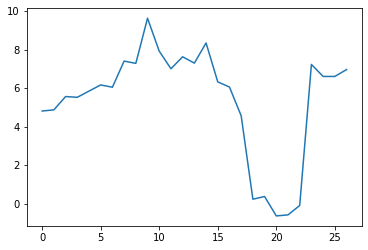

In [26]:
chg.z.plot()

In [27]:
pd.read_sql("SELECT max(week) FROM projections WHERE year=2024", engine)

,max(week)
0,28


### Weekly Sit or Start Decisions

In [28]:
current_period

29

In [29]:
ids = fp.load_id_map()

In [33]:
for key, val in eligibility_url_dict.items():
    print(val, key)
    try:
        data = get_weekly_sit_or_start_by_owner(key, val, ids, current_period-1, current_period)
        if data.shape[0] > 0:
            data['decision'] = data['Decision'].apply(lambda x: x.lower()) #.rename(columns={'Decision':'decision'})
            data[data['week']==current_period-1][['cbsid', 'owner_id', 'year', 'week', 'pos', 'decision']]\
                .to_sql('roster', con=engine, if_exists='append', index=False)
    except:
        print(f"There was an error processing {val}")

30 9 Grand Kids
There was an error processing 30
3 Brewbirds
There was an error processing 3
36 Charmer
There was an error processing 36
41 Dirty Birds
There was an error processing 41
4 Harveys Wallbangers
There was an error processing 4
27 Lil Trump & the Ivanabees
There was an error processing 27
38 Lima Time!
There was an error processing 38
44 Roid Ragers
There was an error processing 44
1 Trouble with the Curve
There was an error processing 1
29 Ugly Spuds
There was an error processing 29
42 Wiscompton Wu-Tang
There was an error processing 42
45 Young Guns
There was an error processing 45
47 Mom's Cookin
There was an error processing 47


In [63]:
data_list = []
for key, val in eligibility_url_dict.items():
    #print(val, key)
    if val!='27':
        data_list.append(pd.read_excel(f"data\\{datetime.now().year}-{key}-sit-start.xlsx"))
sit_start = pd.concat(data_list)
sit_start = sit_start[sit_start['week']==current_period-1].drop_duplicates()
sit_start['Decision'] = sit_start['Decision'].apply(lambda x: x.lower())
sit_start.rename(columns={'Decision':'decision'},inplace=True)
sit_start

,CBSNAME,Owner,week,Team,pos,decision,cbsid,MLBID,IDFANGRAPHS,year,owner_id


In [76]:
sit_start[['cbsid', 'owner_id', 'year', 'week', 'pos', 'decision']]\
    .to_sql('roster', con=engine, if_exists='append', index=False)

In [79]:
pd.read_sql(f"SELECT * FROM roster WHERE year=2024 AND week={current_period-1}", engine)

,cbsid,owner_id,year,week,pos,decision
0,1793168,30,2024,28,C,start
1,2837704,30,2024,28,1B,start
2,2167464,30,2024,28,2B,start
3,1765812,30,2024,28,3B,start
4,26615356,30,2024,28,SS,start
...,...,...,...,...,...,...
391,2050483,47,2024,28,SP,sit
392,2165932,47,2024,28,SP,sit
393,2167338,47,2024,28,SP,sit
394,2118874,47,2024,28,RP,sit


In [50]:
stmt = "UPDATE roster SET decision='sit' WHERE decision='Sit'"
cursor = conn.cursor()
cursor.execute(stmt)

stmt = "UPDATE roster SET decision='start' WHERE decision='Start'"
cursor = conn.cursor()
cursor.execute(stmt)

conn.commit()

AttributeError: 'Engine' object has no attribute 'cursor'

In [80]:
dups = pd.read_sql(f"SELECT cbsid, count(*) Count FROM roster WHERE year=2024 AND week={current_period-1} GROUP BY cbsid HAVING count(*)>1", engine)
dups.sort_values('cbsid')

,cbsid,Count


In [81]:
pd.read_sql(f"SELECT * FROM roster WHERE year=2024 AND week=23 AND cbsid=2901324", engine)

,cbsid,owner_id,year,week,pos,decision
0,2901324,36,2024,23,DH,start


In [47]:
",".join([str(v) for v in list(dups.cbsid.unique())])

'2901324'

In [48]:
pd.read_sql(f"SELECT * FROM roster WHERE year=2024 AND week={current_period-1} AND cbsid IN ({','.join([str(v) for v in list(dups.cbsid.unique())])}) ORDER BY cbsid", engine)['owner_id'].unique()

array([36], dtype=int64)

In [101]:
# Delete statement

# Create an engine
engine = create_engine('sqlite:///fantasy_data.db', echo=False)

# Using a connection with a transaction context manager
with engine.connect() as connection:
    # Begin a transaction explicitly
    with connection.begin() as transaction:
        #delete_statement = text("DELETE FROM roster WHERE year=:year AND week>=:week")
        #delete_statement = text("DELETE FROM projections WHERE week=:week AND year=:year AND proj_type=:proj_type")
        #delete_statement = text("DELETE FROM stats WHERE year=:year AND week=:week")
        #delete_statement = text("DELETE FROM roster WHERE year=:year AND week=:week AND cbsid=:cbsid")
        insert_statement = text("INSERT INTO roster (cbsid, owner_id, year, week, pos, decision) VALUES (2901324, 36, 2024, 23, 'DH', 'start')")
        #update_statement = text("UPDATE roster SET decision='start' WHERE decision='Start'")
        #connection.execute(update_statement)
        #esult = connection.execute(delete_statement, {'year': 2024, 'week': 23, 'proj_type':'ros', 'cbsid':2901324})
        result = connection.execute(insert_statement)
        # Transaction is committed or rolled back automatically at the end of the context block


In [47]:
with engine.connect() as connection:
    with connection.begin() as transaction:
        #connection.execute(text("ALTER TABLE roster ADD decision VARCHAR(5)"))
        #connection.execute(text("DELETE FROM roster WHERE year=2024"))
        #connection.execute(text("DELETE FROM eligibility WHERE year=2024 and week=17"))

In [55]:
pd.read_sql("SELECT * FROM projections WHERE week=21 and year=2024", engine)

,cbsid,year,week,proj_type,AB,R,H,HR,RBI,BB,SB,BA,IP,W,SO,Sv+Hld,BBa,Ha,ERA,WHIP,ER,z


In [46]:
pd.read_sql("SELECT * FROM roster where owner_id=1 AND week>25 and year=2024", engine)

,cbsid,owner_id,year,week,pos,decision
0,2483273,1,2024,26,C,start
1,2121030,1,2024,26,1B,start
2,2910610,1,2024,26,2B,start
3,2135256,1,2024,26,3B,start
4,3117472,1,2024,26,SS,start
...,...,...,...,...,...,...
61,2835074,1,2024,26,SP,sit
62,1225651,1,2024,26,SP,sit
63,1765806,1,2024,26,SP,sit
64,2117048,1,2024,26,RP,sit


In [56]:
df = pd.DataFrame()
for owner in team_list:
    print(owner)
    df = pd.concat([df,pd.read_excel(f"data\\2024-{owner}-sit-start.xlsx")])

df.rename(columns={'Decision':'decision'},inplace=True)
df['decision'] = df['decision'].str.lower()

Lima Time!
Ugly Spuds
Harveys Wallbangers
Roid Ragers
Charmer
Wiscompton Wu-Tang
9 Grand Kids
Brewbirds
Trouble With The Curve
Mom's Cookin
Dirty Birds
Young Guns


In [19]:
df[df['week']>13][['cbsid', 'owner_id', 'year', 'week', 'pos', 'decision']].to_sql('roster', index=False, con=engine, if_exists='append')

In [47]:
pd.read_sql(f"SELECT s.*, r.owner_id, r.decision, r.pos \
        FROM roster r \
        INNER JOIN stats s On (r.cbsid=s.cbsid and r.week=s.week and r.year=s.year) \
        WHERE r.year=2024 AND decision='start'", engine).groupby('owner_id').agg({'HR':'sum', 'R':'sum', 'RBI':'sum', 'SB':'sum', 'H':'sum', 'AB':'sum'})

,HR,R,RBI,SB,H,AB
owner_id,,,,,,
1,274.0,1022.0,957.0,155.0,1808.0,7015.0
3,288.0,1057.0,1002.0,187.0,1943.0,7472.0
4,300.0,1077.0,966.0,181.0,1872.0,7421.0
29,221.0,915.0,835.0,277.0,1736.0,6970.0
30,290.0,1025.0,1001.0,163.0,1926.0,7345.0
36,295.0,1050.0,966.0,258.0,1848.0,7310.0
38,281.0,1004.0,1064.0,169.0,1889.0,7353.0
41,216.0,893.0,844.0,98.0,1698.0,7054.0
42,275.0,1001.0,976.0,191.0,1723.0,7095.0


In [59]:
def fill_pos(row):
    for pos in row['Pos'].split('/'):
        print(pos)
        data.loc[data['cbsid']==row['cbsid'], pos] = 5
    return row

### Weekly Stats
Begin loop code

In [106]:
wk = pd.read_sql("SELECT MAX(week) wk FROM stats WHERE year=2024",engine).iloc[0]['wk']
wk

27

In [107]:
df = pd.DataFrame()
#wk = 18

In [108]:
# pitching
#driver.get(f'https://xdl.baseball.cbssports.com/stats/stats-main/all:SP:RP/period-{wk+1}:p/standard/stats?print_rows=9999')
# hitting
driver.get(f'https://xdl.baseball.cbssports.com/stats/stats-main/all:C:1B:2B:3B:SS:MI:CI:OF:DH/period-{wk+1}:p/standard/stats?print_rows=9999')
# Then need to click "All"

In [109]:
wk

27

In [110]:
wk += 1
html = driver.page_source
soup = bs4(html, 'html.parser')
data = pd.read_html(str(soup.find_all('table')))[0]
data.columns = data.columns.droplevel()
data['cbsid'] = data.Action.apply(lambda txt: -1 if len(re.findall(r'\b\d{5,}\b', txt))==0 else re.findall(r'\b\d{5,}\b', txt)[0])
data['cbsid'] = data.cbsid.astype(int)
data = data.iloc[:-1, 1:]
data['Rank'] = data['Rank'].astype(int)
data = data[(data['Avail']!='FA') | (data['Rank']<9999)]
try:
    data['Team'] = data.Player.apply(lambda x: x.split()[-1])
except:
    pass
try:
    data['Player'] = data.Player.apply(lambda x: ' '.join(x.split()[:-3]))
except:
    pass
data['Week'] = wk
#id_dict = {int(i['href'].split('/')[-1]):[i.text, i['aria-label'].split(' ')[-1]] for i in soup.find_all("a", {"class": "playerLink"}, href=True) if i.text!=''}
#id_df = pd.DataFrame(id_dict, index=['CBSNAME', 'Team']).T
#data = data.merge(id_df.reset_index(), left_on=['Player', 'Team'], right_on=['CBSNAME', 'Team'], how='left')

df = pd.concat([df,data])

In [111]:
df.shape

(431, 21)

In [112]:
data

,Avail,Player,AB,R,H,1B,2B,3B,HR,RBI,BB,K,SB,CS,AVG,OBP,SLG,Rank,cbsid,Team,Week
0,Charme...,Shohei Ohtani,25.0,6.0,13.0,8.0,4.0,0.0,1.0,7.0,3.0,2.0,4.0,0.0,0.520,0.571,0.800,1,2901324,LAD,28
1,Harvey...,Wyatt Langford,24.0,7.0,6.0,3.0,0.0,0.0,3.0,5.0,4.0,5.0,3.0,0.0,0.250,0.357,0.625,11,29153543,TEX,28
2,FA,Jonah Bride,25.0,4.0,11.0,6.0,2.0,0.0,3.0,8.0,2.0,5.0,0.0,0.0,0.440,0.464,0.880,13,26861425,MIA,28
3,Harvey...,Xavier Edwards,27.0,8.0,13.0,7.0,3.0,3.0,0.0,7.0,5.0,5.0,1.0,1.0,0.481,0.562,0.815,14,2931936,MIA,28
4,Lil Tr...,Nate Lowe,23.0,6.0,8.0,3.0,2.0,0.0,3.0,8.0,3.0,5.0,0.0,0.0,0.348,0.423,0.826,18,2920354,TEX,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,Ugly S...,Oneil Cruz,19.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.000,0.136,0.000,861,2822182,PIT,28
427,FA,Jose Tena,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.000,0.050,0.000,864,3107923,WAS,28
590,Brewbi...,Willson Contreras,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,9999,2171084,STL,28
767,Young ...,Ha-seong Kim,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,9999,26608279,SD,28


In [157]:
#time.sleep(2)
if wk < current_period:
    #driver.get(f'https://xdl.baseball.cbssports.com/stats/stats-main/all:C:1B:2B:3B:SS:MI:CI:OF:DH/period-{wk+1}:p/standard/stats?print_rows=9999')
    driver.get(f'https://xdl.baseball.cbssports.com/stats/stats-main/all:SP:RP/period-{wk+1}:p/standard/stats?print_rows=9999')

### End looping code

In [113]:
df.rename(columns={'Avail':'Owner', 'Week':'week'},inplace=True)
df = df.replace(name_change)
df['year'] = datetime.now().year

In [99]:
df['outs'] = df.INNs.apply(lambda x: (int(str(x).split('.')[0])*3) + int(str(x).split('.')[1]))
df['IP'] = round(df['outs']/3.,2)
df['ER'] = round(df['ERA']*df['IP']/9.,1)
df['SvHld'] = df['S']+df['HD']
df.rename(columns={'K':'SO', 'H':'Ha', 'BB':'BBa'}, inplace=True)

In [114]:
df.head()

,Owner,Player,AB,R,H,1B,2B,3B,HR,RBI,BB,K,SB,CS,AVG,OBP,SLG,Rank,cbsid,Team,week,year
0,Charmer,Shohei Ohtani,25.0,6.0,13.0,8.0,4.0,0.0,1.0,7.0,3.0,2.0,4.0,0.0,0.520,0.571,0.800,1,2901324,LAD,28,2024
1,Harveys Wallbangers,Wyatt Langford,24.0,7.0,6.0,3.0,0.0,0.0,3.0,5.0,4.0,5.0,3.0,0.0,0.250,0.357,0.625,11,29153543,TEX,28,2024
2,FA,Jonah Bride,25.0,4.0,11.0,6.0,2.0,0.0,3.0,8.0,2.0,5.0,0.0,0.0,0.440,0.464,0.880,13,26861425,MIA,28,2024
3,Harveys Wallbangers,Xavier Edwards,27.0,8.0,13.0,7.0,3.0,3.0,0.0,7.0,5.0,5.0,1.0,1.0,0.481,0.562,0.815,14,2931936,MIA,28,2024
4,Lil Trump & the Ivanabees,Nate Lowe,23.0,6.0,8.0,3.0,2.0,0.0,3.0,8.0,3.0,5.0,0.0,0.0,0.348,0.423,0.826,18,2920354,TEX,28,2024


In [115]:
df[['cbsid', 'year', 'week', 'R', 'RBI', 'HR', 'SB', 'H', 'AB']]

,cbsid,year,week,R,RBI,HR,SB,H,AB
0,2901324,2024,28,6.0,7.0,1.0,4.0,13.0,25.0
1,29153543,2024,28,7.0,5.0,3.0,3.0,6.0,24.0
2,26861425,2024,28,4.0,8.0,3.0,0.0,11.0,25.0
3,2931936,2024,28,8.0,7.0,0.0,1.0,13.0,27.0
4,2920354,2024,28,6.0,8.0,3.0,0.0,8.0,23.0
...,...,...,...,...,...,...,...,...,...
426,2822182,2024,28,1.0,0.0,0.0,0.0,0.0,19.0
427,3107923,2024,28,0.0,0.0,0.0,0.0,0.0,19.0
590,2171084,2024,28,0.0,0.0,0.0,0.0,0.0,0.0
767,26608279,2024,28,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
dfh = pd.read_excel('data//2024-weekly-stats-h.xlsx')
dfh.fillna(0,inplace=True)
dfh.shape

(10968, 9)

In [102]:
dfh.tail()

,cbsid,year,week,R,RBI,HR,SB,H,AB
10963,2942965,2024,27,3,2,1,0,6,23
10964,1811026,2024,27,3,2,1,0,5,19
10965,2184448,2024,27,5,2,2,0,4,27
10966,2836722,2024,27,1,2,0,1,7,22
10967,2167340,2024,27,0,0,0,0,0,0


In [116]:
pd.concat([dfh,df[['cbsid', 'year', 'week', 'R', 'RBI', 'HR', 'SB', 'H', 'AB']]]).sort_values('week')\
    .to_excel('data//2024-weekly-stats-h.xlsx', index=False)

In [103]:
dfp = pd.read_excel('data//2024-weekly-stats-p.xlsx')
dfp.fillna(0,inplace=True)
dfp.shape

(11087, 11)

In [104]:
dfp

,cbsid,year,week,W,SO,SvHld,ER,Ha,BBa,IP,outs
0,1697836,2024,1,1,1,0,0.0,1,0,1.00,3
1,26861461,2024,1,0,2,1,0.0,1,0,1.33,4
2,2779811,2024,1,0,1,1,0.0,0,0,1.00,3
3,1937347,2024,1,0,3,0,0.0,2,3,3.67,11
4,2918658,2024,1,1,5,0,3.0,4,3,3.33,10
...,...,...,...,...,...,...,...,...,...,...,...
11082,2223751,2024,27,0,0,0,0.0,0,0,0.00,0
11083,2910624,2024,27,0,0,0,0.0,0,0,0.00,0
11084,2066291,2024,27,0,0,0,0.0,0,0,0.00,0
11085,2227187,2024,27,0,0,0,0.0,0,0,0.00,0


In [105]:
#pd.concat([dfh,df[['cbsid', 'year', 'week', 'R', 'RBI', 'HR', 'SB', 'H', 'AB']]]).to_excel('data//2024-weekly-stats-h.xlsx', index=False)
pd.concat([dfp.rename(columns={'SvHLD':'SvHld'}),df[['cbsid', 'year', 'week', 'W', 'SO', 'SvHld', 'ER', 'Ha', 'BBa', 'IP', 'outs']]])\
    .to_excel('data//2024-weekly-stats-p.xlsx', index=False)

In [117]:
pd.read_sql("SELECT * FROM stats", engine).sort_values(['year', 'week'])

,cbsid,year,week,R,RBI,HR,SB,H,AB,W,SO,SvHld,ER,Ha,BBa,IP,outs
0,288897,2023,1,0.0,1.0,0.0,0.0,2.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,390851,2023,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,0.0,2.0,6.0,1.0,5.33,16.0
83,530355,2023,1,0.0,0.0,0.0,0.0,0.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,547421,2023,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.00,3.0
139,555244,2023,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,0.0,3.0,3.0,2.0,5.00,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43055,29033792,2024,27,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5.0,0.0,1.0,2.0,2.0,3.00,9.0
43056,26615423,2024,27,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,2.0,1.0,2.00,6.0
43057,2167335,2024,27,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,0.0,3.0,9.0,4.0,8.00,24.0
43058,2837138,2024,27,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,0.0,4.0,6.0,0.0,2.00,6.0


In [118]:
dfh = pd.read_excel('data//2024-weekly-stats-h.xlsx')
dfh.fillna(0,inplace=True)
dfp = pd.read_excel('data//2024-weekly-stats-p.xlsx')
dfp.fillna(0,inplace=True)

df = dfh.merge(dfp, on='cbsid', suffixes=['', '_p'], how='outer')
df['year'].fillna(2024,inplace=True)
df['week'].fillna(df['week_p'], inplace=True)
df.drop(columns=['year_p', 'week_p'],inplace=True)

In [119]:
df[df['week'].isin([wk])][['cbsid', 'year', 'week', 'R', 'RBI', 'HR', 'SB', 'H', 'AB', 'W', 'SO',
       'SvHld', 'ER', 'Ha', 'BBa', 'IP', 'outs']]#.duplicated('cbsid').sum()

,cbsid,year,week,R,RBI,HR,SB,H,AB,W,SO,SvHld,ER,Ha,BBa,IP,outs
23,2106654,2024.0,28.0,1.0,2.0,0.0,0.0,3.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,2914723,2024.0,28.0,2.0,2.0,0.0,0.0,4.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,2932701,2024.0,28.0,2.0,5.0,1.0,0.0,8.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,2184448,2024.0,28.0,2.0,3.0,0.0,0.0,5.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,1755142,2024.0,28.0,2.0,1.0,0.0,0.0,5.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23658,3157975,2024.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,1.0,0.0,2.33,7.0
23659,28840801,2024.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.0,0.0,1.00,3.0
23660,26615457,2024.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,2.0,0.0,1.33,4.0
23661,2822952,2024.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,3.0,1.0,2.00,6.0


In [120]:
s = df[df['week'].isin([wk])].duplicated(keep=False)
df[df.index.isin(s[s].index)]

,cbsid,year,week,R,RBI,HR,SB,H,AB,W,SO,SvHld,ER,Ha,BBa,IP,outs
1057,2901324,2024.0,28.0,6.0,7.0,1.0,4.0,13.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1058,2901324,2024.0,28.0,6.0,7.0,1.0,4.0,13.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1059,2901324,2024.0,28.0,6.0,7.0,1.0,4.0,13.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1060,2901324,2024.0,28.0,6.0,7.0,1.0,4.0,13.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1061,2901324,2024.0,28.0,6.0,7.0,1.0,4.0,13.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1062,2901324,2024.0,28.0,6.0,7.0,1.0,4.0,13.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1063,2901324,2024.0,28.0,6.0,7.0,1.0,4.0,13.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1064,2901324,2024.0,28.0,6.0,7.0,1.0,4.0,13.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1065,2901324,2024.0,28.0,6.0,7.0,1.0,4.0,13.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1066,2901324,2024.0,28.0,6.0,7.0,1.0,4.0,13.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
# Upload to stats table

#df[(df['week'].isin([wk])) & (df['AB']>=0)]
df[(df['week'].isin([wk]))][['cbsid', 'year', 'week', 'R', 'RBI', 'HR', 'SB', 'H', 'AB', 'W', 'SO', 'SvHld', 'ER', 'Ha', 'BBa', 'IP', 'outs']]\
    .to_sql('stats', if_exists='append', con=engine, index=False)

In [122]:
pd.read_sql('SELECT * FROM stats WHERE year=2024 AND AB IS NOT NULL ORDER BY week', engine)

,cbsid,year,week,R,RBI,HR,SB,H,AB,W,SO,SvHld,ER,Ha,BBa,IP,outs
0,2106654,2024,1,2.0,7.0,1.0,0.0,6.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2447496,2024,1,2.0,4.0,0.0,0.0,4.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1945481,2024,1,3.0,3.0,0.0,0.0,4.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1765812,2024,1,3.0,3.0,1.0,0.0,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2250617,2024,1,1.0,2.0,0.0,0.0,5.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11421,3152050,2024,28,0.0,2.0,0.0,0.0,2.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11422,2120665,2024,28,2.0,0.0,0.0,0.0,2.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11423,26913029,2024,28,1.0,0.0,0.0,0.0,1.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11424,2211204,2024,28,2.0,3.0,1.0,0.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
